In [30]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import matplotlib.pyplot as plt

from facenet_pytorch.models.mtcnn import *

In [48]:
device = torch.device('cpu')
device

device(type='cpu')

In [ ]:
mtcnn = MTCNN()

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [79]:
from PIL import Image

img = Image.open('picture.jpg')

# Get cropped and prewhitened image tensor
img_cropped, prob = mtcnn(img, return_prob=True)

# Calculate embedding (unsqueeze to add batch dimension)
img_embedding = resnet(img_cropped.unsqueeze(0))

# Or, if using for VGGFace2 classification
resnet.classify = True
img_probs = resnet(img_cropped.unsqueeze(0))

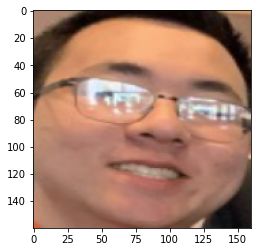

In [80]:
plt.imshow(img_cropped.transpose(0,2).transpose(0,1) * .5 + .5)

In [54]:
from facenet_pytorch.models.utils.detect_face import *

In [76]:
def detect_face(imgs, minsize, pnet, rnet, onet, threshold, factor, device):
    # if isinstance(imgs, (np.ndarray, torch.Tensor)):
    #     if isinstance(imgs,np.ndarray):
    #         imgs = torch.as_tensor(imgs.copy(), device=device)
    #
    #     if isinstance(imgs,torch.Tensor):
    #         imgs = torch.as_tensor(imgs, device=device)
    #
    if len(imgs.shape) == 3:
        imgs = imgs.unsqueeze(0)
    # else:
    #     if not isinstance(imgs, (list, tuple)):
    #         imgs = [imgs]
    #     if any(img.size != imgs[0].size for img in imgs):
    #         raise Exception("MTCNN batch processing only compatible with equal-dimension images.")
    #     imgs = np.stack([np.uint8(img) for img in imgs])
    #     imgs = torch.as_tensor(imgs.copy(), device=device)



    model_dtype = next(pnet.parameters()).dtype
    imgs = imgs.permute(0, 3, 1, 2).type(model_dtype)

    batch_size = len(imgs)
    h, w = imgs.shape[2:4]
    m = 12.0 / minsize
    minl = min(h, w)
    minl = minl * m

    # Create scale pyramid
    scale_i = m
    scales = []
    while minl >= 12:
        scales.append(scale_i)
        scale_i = scale_i * factor
        minl = minl * factor

    # First stage
    boxes = []
    image_inds = []

    scale_picks = []

    all_i = 0
    offset = 0
    for scale in scales:
        im_data = imresample(imgs, (int(h * scale + 1), int(w * scale + 1)))
        im_data = (im_data - 127.5) * 0.0078125
        reg, probs = pnet(im_data)

        boxes_scale, image_inds_scale = generateBoundingBox(reg, probs[:, 1], scale, threshold[0])
        boxes.append(boxes_scale)
        image_inds.append(image_inds_scale)

        pick = batched_nms(boxes_scale[:, :4], boxes_scale[:, 4], image_inds_scale, 0.5)
        scale_picks.append(pick + offset)
        offset += boxes_scale.shape[0]

    boxes = torch.cat(boxes, dim=0)
    image_inds = torch.cat(image_inds, dim=0)

    scale_picks = torch.cat(scale_picks, dim=0)

    # NMS within each scale + image
    boxes, image_inds = boxes[scale_picks], image_inds[scale_picks]


    # NMS within each image
    pick = batched_nms(boxes[:, :4], boxes[:, 4], image_inds, 0.7)
    boxes, image_inds = boxes[pick], image_inds[pick]

    regw = boxes[:, 2] - boxes[:, 0]
    regh = boxes[:, 3] - boxes[:, 1]
    qq1 = boxes[:, 0] + boxes[:, 5] * regw
    qq2 = boxes[:, 1] + boxes[:, 6] * regh
    qq3 = boxes[:, 2] + boxes[:, 7] * regw
    qq4 = boxes[:, 3] + boxes[:, 8] * regh
    boxes = torch.stack([qq1, qq2, qq3, qq4, boxes[:, 4]]).permute(1, 0)
    boxes = rerec(boxes)
    y, ey, x, ex = pad(boxes, w, h)

    # Second stage
    if len(boxes) > 0:
        im_data = []
        for k in range(len(y)):
            if ey[k] > (y[k] - 1) and ex[k] > (x[k] - 1):
                img_k = imgs[image_inds[k], :, (y[k] - 1):ey[k], (x[k] - 1):ex[k]].unsqueeze(0)
                im_data.append(imresample(img_k, (24, 24)))
        im_data = torch.cat(im_data, dim=0)
        im_data = (im_data - 127.5) * 0.0078125

        # This is equivalent to out = rnet(im_data) to avoid GPU out of memory.
        out = fixed_batch_process(im_data, rnet)

        out0 = out[0].permute(1, 0)
        out1 = out[1].permute(1, 0)
        score = out1[1, :]
        ipass = score > threshold[1]
        boxes = torch.cat((boxes[ipass, :4], score[ipass].unsqueeze(1)), dim=1)
        image_inds = image_inds[ipass]
        mv = out0[:, ipass].permute(1, 0)

        # NMS within each image
        pick = batched_nms(boxes[:, :4], boxes[:, 4], image_inds, 0.7)
        boxes, image_inds, mv = boxes[pick], image_inds[pick], mv[pick]
        boxes = bbreg(boxes, mv)
        boxes = rerec(boxes)

    # Third stage
    points = torch.zeros(0, 5, 2, device=device)
    if len(boxes) > 0:
        y, ey, x, ex = pad(boxes, w, h)
        im_data = []
        for k in range(len(y)):
            if ey[k] > (y[k] - 1) and ex[k] > (x[k] - 1):
                img_k = imgs[image_inds[k], :, (y[k] - 1):ey[k], (x[k] - 1):ex[k]].unsqueeze(0)
                im_data.append(imresample(img_k, (48, 48)))
        im_data = torch.cat(im_data, dim=0)
        im_data = (im_data - 127.5) * 0.0078125

        # This is equivalent to out = onet(im_data) to avoid GPU out of memory.
        out = fixed_batch_process(im_data, onet)

        out0 = out[0].permute(1, 0)
        out1 = out[1].permute(1, 0)
        out2 = out[2].permute(1, 0)
        score = out2[1, :]
        points = out1
        ipass = score > threshold[2]
        points = points[:, ipass]
        boxes = torch.cat((boxes[ipass, :4], score[ipass].unsqueeze(1)), dim=1)
        image_inds = image_inds[ipass]
        mv = out0[:, ipass].permute(1, 0)

        w_i = boxes[:, 2] - boxes[:, 0] + 1
        h_i = boxes[:, 3] - boxes[:, 1] + 1
        points_x = w_i.repeat(5, 1) * points[:5, :] + boxes[:, 0].repeat(5, 1) - 1
        points_y = h_i.repeat(5, 1) * points[5:10, :] + boxes[:, 1].repeat(5, 1) - 1
        points = torch.stack((points_x, points_y)).permute(2, 1, 0)
        boxes = bbreg(boxes, mv)

        # NMS within each image using "Min" strategy
        # pick = batched_nms(boxes[:, :4], boxes[:, 4], image_inds, 0.7)
        pick = batched_nms_numpy(boxes[:, :4], boxes[:, 4], image_inds, 0.7, 'Min')
        boxes, image_inds, points = boxes[pick], image_inds[pick], points[pick]

    boxes = boxes.cpu().numpy()
    points = points.cpu().numpy()

    image_inds = image_inds.cpu()

    batch_boxes = []
    batch_points = []
    for b_i in range(batch_size):
        b_i_inds = np.where(image_inds == b_i)
        batch_boxes.append(boxes[b_i_inds])
        batch_points.append(points[b_i_inds])

    batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)

    return batch_boxes, batch_points

In [77]:
image_size=160
margin=0
min_face_size=20
thresholds=[0.6, 0.7, 0.7]
factor=0.709
pnet = PNet()
rnet = RNet()
onet = ONet()

with torch.no_grad():
    img = Image.open('picture.jpg')
    img = torch.Tensor(np.array(img))
    img.requires_grad = True
    batch_boxes, batch_points = detect_face(img, min_face_size,
                    pnet, rnet, onet,
                    thresholds, factor, torch.device('cpu')
    )
    print(img.grad)

None


In [130]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image

In [131]:
def fgsm(model, image, target_image, epsilon=.15):

    image = torch.Tensor(np.array(image)).unsqueeze(0)
    target_image = torch.Tensor(np.array(target_image)).unsqueeze(0)
    image.requires_grad = True

    # Forward pass the data through the model
    output = model(image)
    target = model(target_image)

    # Calculate the loss
    loss = nn.CosineSimilarity()(output, target)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = image.grad.data

    # Call FGSM Attack
    perturbed_data = fgsm_attack(image, epsilon, data_grad)

    # Re-classify the perturbed image
    fgsm_output = model(perturbed_data)

    return perturbed_data, target, output, fgsm_output

In [159]:
b = mtcnn(Image.open('val.jpg'))
a = mtcnn(Image.open('parth.jpg'))
perturbed_data, target, output, fgsm_output = fgsm(resnet, a, b, .05)

In [160]:
cos = nn.CosineSimilarity()
print('t-o', cos(target, output).item())
print('t-f', cos(target, fgsm_output).item())
print('o-f', cos(output, fgsm_output).item())

t-o 0.1406058371067047
t-f 0.6863094568252563
o-f 0.5443805456161499


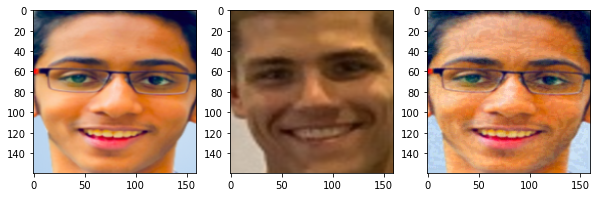

In [161]:
def plottable_img(img):
    return img.squeeze().detach().numpy().transpose((1,2,0)) * .5 + .5

fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].imshow(plottable_img(a))
ax[1].imshow(plottable_img(b))
ax[2].imshow(plottable_img(perturbed_data))